In [43]:
import sys
sys.path.append("C:\\Users\\Sheng\\epstein_network_civil_violence")
import math

from epstein_civil_violence.agent import Citizen, Cop


class Inhabitant(Citizen):

    def __init__(
            self,
            unique_id,
            model,
            pos,
            hardship,
            regime_legitimacy,
            risk_aversion,
            threshold,
            vision,
            alpha,
            rumor_effect,
    ):
        """
        Create a new Inhabitant.
        Args:
            unique_id: unique int
            x, y: Grid coordinates
            hardship: Agent's 'perceived hardship (i.e., physical or economic
                privation).' Exogenous, drawn from U(0,1).
            regime_legitimacy: Agent's perception of regime legitimacy, equal
                across agents.  Exogenous.
            risk_aversion: Exogenous, drawn from U(0,1).
            threshold: if (grievance - (risk_aversion * arrest_probability)) >
                threshold, go/remain Active
            vision: number of cells in each direction (N, S, E and W) that
                agent can inspect. Exogenous.
            model: model instance
            alpha: Deterrent effect.
            rumor_effect: Network rumor effect posed by active agents.
            cops_in_vision: number of cops in the vision.
            actives_in_vision: number of active agents in the vision.
        """

        super().__init__(
            unique_id,
            model,
            pos,
            hardship,
            regime_legitimacy,
            risk_aversion,
            threshold,
            vision)
        self.breed = "citizen"
        self.condition = "Quiescent"
        self.jail_sentence = 0
        self.grievance = self.hardship * (1 - self.regime_legitimacy)
        self.arrest_probability = None
        self.alpha = alpha
        self.rumor_effect = rumor_effect
        self.cops_in_vision = 0
        self.actives_in_vision = 0

    def update_estimated_arrest_probability(self):
        """
        Based on the ratio of cops to actives in my neighborhood, estimate the
        p(Arrest | I go active).
        """
        cops_in_vision = len([c for c in self.neighbors if c.breed == "cop"])
        actives_in_vision = 1.0  # citizen counts herself
        for c in self.neighbors:
            if (
                    c.breed == "citizen"
                    and c.condition == "Active"
                    and c.jail_sentence == 0
            ):
                actives_in_vision += 1
        self.arrest_probability = 1 - math.exp(
            -1 * self.model.arrest_prob_constant * (cops_in_vision / actives_in_vision)
        )
        self.cops_in_vision = cops_in_vision
        self.actives_in_vision = actives_in_vision

    def step(self):
        """
        Decide whether to activate, then move if applicable.
        """
        if self.jail_sentence:
            self.jail_sentence -= 1
            return  # no other changes or movements if agent is in jail.
        self.update_neighbors()
        self.update_estimated_arrest_probability()
        net_risk = self.risk_aversion * self.arrest_probability * self.jail_sentence ** self.alpha

        if self.condition == "Quiescent":
            if self.grievance - net_risk > self.threshold and self.actives_in_vision >= (1 * self.cops_in_vision):
                self.condition = "Active"
            else:
                self.condition = "Quiescent"
        else:
            if self.grievance - net_risk < self.threshold or self.cops_in_vision >= 1:
                self.condition = "Quiescent"

        if self.model.movement and self.empty_neighbors:
            new_pos = self.random.choice(self.empty_neighbors)
            self.model.grid.move_agent(self, new_pos)

    def spreading_rumor(self):
        # TODO
        pass


class Police(Cop):
    def step(self):
        """
        Inspect local vision and arrest a random active agent. Move if
        applicable.
        """
        self.update_neighbors()
        active_neighbors = []
        for agent in self.neighbors:
            if (
                    agent.breed == "citizen"
                    and agent.condition == "Active"
                    and agent.jail_sentence == 0
            ):
                active_neighbors.append(agent)
        if active_neighbors:
            arrestee = self.random.choice(active_neighbors)
            if self.random.random() < arrestee.arrest_probability:
                sentence = self.random.randint(0, self.model.max_jail_term)
                arrestee.jail_sentence = sentence
                arrestee.condition = "Quiescent"
        if self.model.movement and self.empty_neighbors:
            new_pos = self.random.choice(self.empty_neighbors)
            self.model.grid.move_agent(self, new_pos)

In [5]:
pip install nest_asyncio

Note: you may need to restart the kernel to use updated packages.


In [44]:
import nest_asyncio
nest_asyncio.apply()

In [66]:
# add new features and mechanisms to collect data for plot
import mesa

from epstein_civil_violence.model import EpsteinCivilViolence
from epstein_network_civil_violence.agent import Inhabitant, Police

class EpsteinNetworkCivilViolence(EpsteinCivilViolence):
    """
    Extended model from Model 1 from "Modeling civil violence: An agent-based computational
    approach," by Joshua Epstein.
    http://www.pnas.org/content/99/suppl_3/7243.full
    Attributes:
        height: grid height
        width: grid width
        citizen_density: approximate % of cells occupied by citizens.
        cop_density: approximate % of cells occupied by cops.
        citizen_vision: number of cells in each direction (N, S, E, and W) that citizen can inspect
        cop_vision: number of cells in each direction (N, S, E, and W) that cop can inspect
        legitimacy: (L) citizens' perception of regime legitimacy, equal across all citizens
        max_jail_term: (J_max)
        active_threshold: if (grievance - (risk_aversion * arrest_probability)) > threshold, citizen rebels
        arrest_prob_constant: set to ensure agents make plausible arrest probability estimates
        movement: binary, whether agents try to move at step end
        max_iters: model may not have a natural stopping point, so we set a max.
        alpha: Deterrent effect.
        rumor_effect: Network rumor effect posed by active agents.
    """
    def __init__(
        self,
        width=40,
        height=40,
        citizen_density=0.7,
        cop_density=0.074,
        citizen_vision=7,
        cop_vision=7,
        legitimacy=0.8,
        max_jail_term=1000,
        active_threshold=0.1,
        arrest_prob_constant=2.3,
        movement=True,
        max_iters=1000,
        alpha=0.1,
        rumor_effect=0.01, 
        cop_density_mode='constant',  # Parameter to select the change mode of cop density (constant, gradual)
        legitimacy_mode='constant'  # Parameter to select the change mode of legitimacy (constant, gradual, drop)
    ):
        # Call the parent class constructor without the new parameters
        super().__init__(
            width,
            height,
            citizen_density,
            cop_density,
            citizen_vision,
            cop_vision,
            legitimacy,
            max_jail_term,
            active_threshold,
            arrest_prob_constant,
            movement,
            max_iters
        )
        
        # Handle the new parameters within the child class
        self.alpha = alpha
        self.rumor_effect = rumor_effect
        self.cop_density_mode = cop_density_mode  # Store the cop density change mode
        self.legitimacy_mode = legitimacy_mode  # Store the legitimacy change mode
        self.active_outburst = False  # Indicates if an outburst is currently happening
        self.last_outburst_ended = 0   # Time the last outburst ended
        self.waiting_times = []  # List to store waiting times
        self.outburst_sizes = []  # Store the size of each outburst
        self.current_outburst_size = 0  # Track the size of the current outburst
        
        model_reporters = {
            "Quiescent": lambda m: self.count_type_citizens(m, "Quiescent"),
            "Active": lambda m: self.count_type_citizens(m, "Active"),
            "Jailed": self.count_jailed,
            "Cops": self.count_cops,
            "Waiting_Times": lambda m: self.waiting_times,
            "Legitimacy": lambda m: self.legitimacy,
            "Cop_Density": lambda m: self.cop_density
            
        }
        agent_reporters = {
            "x": lambda a: a.pos[0],
            "y": lambda a: a.pos[1],
            "breed": lambda a: a.breed,
            "jail_sentence": lambda a: getattr(a, "jail_sentence", None),
            "condition": lambda a: getattr(a, "condition", None),
            "arrest_probability": lambda a: getattr(a, "arrest_probability", None),
        }
        self.datacollector = mesa.DataCollector(
            model_reporters=model_reporters, agent_reporters=agent_reporters
        )
        unique_id = 0
        if self.cop_density + self.citizen_density > 1:
            raise ValueError("Cop density + citizen density must be less than 1")
        for contents, (x, y) in self.grid.coord_iter():
            if self.random.random() < self.cop_density:
                cop = Police(unique_id, self, (x, y), vision=self.cop_vision)
                unique_id += 1
                self.grid[x][y] = cop
                self.schedule.add(cop)
            elif self.random.random() < (self.cop_density + self.citizen_density):
                citizen = Inhabitant(
                    unique_id,
                    self,
                    (x, y),
                    hardship=self.random.random(),
                    regime_legitimacy=self.legitimacy,
                    risk_aversion=self.random.random(),
                    threshold=self.active_threshold,
                    vision=self.citizen_vision,
                    alpha=self.alpha,
                    rumor_effect=self.rumor_effect,
                )
                unique_id += 1
                self.grid[x][y] = citizen
                self.schedule.add(citizen)

        self.running = True
        self.datacollector.collect(self)
    def step(self):
        super().step()
        active_count = self.count_type_citizens(self, "Active")  # Define and calculate the current number of active citizens
        print(f"Active Count: {active_count}")

        if self.iteration == 300 and self.legitimacy_mode == 'drop':
            self.legitimacy = max(0, self.legitimacy - 0.3) 
        elif self.legitimacy_mode == 'gradual':
            self.legitimacy = max(0, self.legitimacy - 0.001) 
        if self.cop_density_mode == 'gradual':
            self.cop_density = max(0, self.cop_density - 0.00005)  # Gradually decrease cop density, but not below 0

        if active_count >= 100 and not self.active_outburst:
            if self.last_outburst_ended != 0:  # Not the first outburst
                wait_time = self.schedule.steps - self.last_outburst_ended
                self.waiting_times.append(wait_time)
                print(f"Outburst starts, wait time recorded: {wait_time}")  # Debug output
            self.active_outburst = True
        if active_count < 100 and self.active_outburst:
            self.last_outburst_ended = self.schedule.steps
            self.active_outburst = False
            print(f"Outburst ends at step {self.last_outburst_ended}")  # Debug output
            
        if active_count >= 100:
            self.current_outburst_size += active_count  # Accumulate the size of the current outburst
        else:
            if self.current_outburst_size > 0:  # An outburst has just ended
                self.outburst_sizes.append(self.current_outburst_size)
                self.current_outburst_size = 0  # Reset for the next outburst
                
        self.schedule.step()
        self.datacollector.collect(self)
        self.iteration += 1 
        if self.iteration > self.max_iters:
            self.running = False


In [46]:
# original model server(figure 1,2,3,4)
import mesa

# from epstein_network_civil_violence.epstein_civil_violence.agent import Cop
from epstein_network_civil_violence.agent import Inhabitant, Police
from epstein_network_civil_violence.model import EpsteinNetworkCivilViolence

COP_COLOR = "#000000"
AGENT_QUIET_COLOR = "#648FFF"
AGENT_REBEL_COLOR = "#FE6100"
JAIL_COLOR = "#808080"
JAIL_SHAPE = "rect"


def citizen_cop_portrayal(agent):
    if agent is None:
        return

    portrayal = {
        "Shape": "circle",
        "x": agent.pos[0],
        "y": agent.pos[1],
        "Filled": "true",
    }

    if type(agent) is Inhabitant:
        color = (
            AGENT_QUIET_COLOR if agent.condition == "Quiescent" else AGENT_REBEL_COLOR
        )
        color = JAIL_COLOR if agent.jail_sentence else color
        shape = JAIL_SHAPE if agent.jail_sentence else "circle"
        portrayal["Color"] = color
        portrayal["Shape"] = shape
        if shape == "rect":
            portrayal["w"] = 0.9
            portrayal["h"] = 0.9
        else:
            portrayal["r"] = 0.5
            portrayal["Filled"] = "false"
        portrayal["Layer"] = 0

    elif type(agent) is Police:
        portrayal["Color"] = COP_COLOR
        portrayal["r"] = 0.9
        portrayal["Layer"] = 1

    return portrayal


model_params = {
    "height": 40,
    "width": 40,
    "citizen_density": mesa.visualization.Slider(
        "Initial Agent Density", 0.7, 0.0, 0.9, 0.1
    ),
    "cop_density": mesa.visualization.Slider(
        "Initial Cop Density", 0.04, 0.0, 0.1, 0.01
    ),
    "citizen_vision": mesa.visualization.Slider("Citizen Vision", 7, 1, 10, 1),
    "cop_vision": mesa.visualization.Slider("Cop Vision", 7, 1, 10, 1),
    "legitimacy": mesa.visualization.Slider(
        "Government Legitimacy", 0.82, 0.0, 1, 0.01
    ),
    "max_jail_term": mesa.visualization.Slider("Max Jail Term", 30, 0, 50, 1),
    "alpha": mesa.visualization.Slider("Alpha", 0.1, 0, 0.5, 0.1),
    "rumor_effect": mesa.visualization.Slider("Rumor Effect", 0.01, 0, 0.05, 0.01),
}
canvas_element = mesa.visualization.CanvasGrid(citizen_cop_portrayal, 40, 40, 480, 480)
chart = mesa.visualization.ChartModule(
    [
        {"Label": "Quiescent", "Color": "#648FFF"},
        {"Label": "Active", "Color": "#FE6100"},
        {"Label": "Jailed", "Color": "#808080"},
    ],
    data_collector_name="datacollector",
)
server = mesa.visualization.ModularServer(
    EpsteinNetworkCivilViolence,
    [
        canvas_element,
        chart,
    ],
    "EpsteinNetworkCivilViolence",
    model_params,
)

In [10]:
# server for Citizen grievance_intensity(figure 1,2)

COP_COLOR = "#000000"
def citizen_grievance_portrayal(agent):
    if agent is None:
        return

    portrayal = {
        "Shape": "circle",
        "x": agent.pos[0],
        "y": agent.pos[1],
        "Filled": "true",
    }

    if type(agent) is Citizen:
        # Adjust color based on level of grievance; lower grievance closer to white
        grievance_intensity = int((1 - agent.grievance) * 255)  # Convert grievance level to color intensity
        color = f'#FF{grievance_intensity:02X}{grievance_intensity:02X}'  # Generate color code
        shape = "circle"
        
        portrayal["Color"] = color
        portrayal["Shape"] = shape
        portrayal["r"] = 0.5  
        portrayal["Filled"] = "true"
        portrayal["Layer"] = 0

    elif type(agent) is Cop:
        portrayal["Color"] = COP_COLOR
        portrayal["r"] = 0.9
        portrayal["Layer"] = 1

    return portrayal

model_params = {
    "height": 40,
    "width": 40,
    "citizen_density": mesa.visualization.Slider(
        "Initial Agent Density", 0.7, 0.0, 0.9, 0.1
    ),
    "cop_density": mesa.visualization.Slider(
        "Initial Cop Density", 0.04, 0.0, 0.1, 0.01
    ),
    "citizen_vision": mesa.visualization.Slider("Citizen Vision", 7, 1, 10, 1),
    "cop_vision": mesa.visualization.Slider("Cop Vision", 7, 1, 10, 1),
    "legitimacy": mesa.visualization.Slider(
        "Government Legitimacy", 0.82, 0.0, 1, 0.01
    ),
    "max_jail_term": mesa.visualization.Slider("Max Jail Term", 30, 0, 50, 1),
}
canvas_element = mesa.visualization.CanvasGrid(citizen_grievance_portrayal, 40, 40, 480, 480)
chart = mesa.visualization.ChartModule(
    [
        {"Label": "Active", "Color": "#FE6100"},
    ],
    data_collector_name="datacollector",
)
server = mesa.visualization.ModularServer(
    EpsteinCivilViolence,
    [
        canvas_element,
        chart,
    ],
    "EpsteinNetworkCivilViolence",
    model_params,
)

In [ ]:
server.launch()

Interface starting at http://127.0.0.1:8521
Socket opened!
{"type":"reset"}
{"type":"get_step","step":1}
{"type":"get_step","step":2}
{"type":"get_step","step":3}
{"type":"get_step","step":4}
{"type":"get_step","step":5}
{"type":"get_step","step":6}
{"type":"get_step","step":7}
{"type":"get_step","step":8}
{"type":"get_step","step":9}
{"type":"get_step","step":10}
{"type":"get_step","step":11}
{"type":"get_step","step":12}
{"type":"get_step","step":13}
{"type":"get_step","step":14}
{"type":"get_step","step":15}
{"type":"get_step","step":16}
{"type":"get_step","step":17}
{"type":"get_step","step":18}
{"type":"get_step","step":19}
{"type":"reset"}


Active Count: 162
Active Count: 82
Outburst ends at step 3
Active Count: 48
Active Count: 38
Active Count: 63
Active Count: 67
Active Count: 63
Active Count: 74
Active Count: 89
Active Count: 100
Outburst starts, wait time recorded: 16
Active Count: 100
Active Count: 97
Outburst ends at step 23
Active Count: 102
Outburst starts, wait time recorded: 2
Active Count: 96
Outburst ends at step 27
Active Count: 96
Active Count: 94
Active Count: 95
Active Count: 95
Active Count: 95
Active Count: 94
Active Count: 100
Outburst starts, wait time recorded: 14
Active Count: 84
Outburst ends at step 43
Active Count: 89
Active Count: 92
Active Count: 86
Active Count: 87
Active Count: 81
Active Count: 86
Active Count: 88
Active Count: 92
Active Count: 88
Active Count: 91
Active Count: 88
Active Count: 99
Active Count: 96
Active Count: 91
Active Count: 95
Active Count: 96
Active Count: 89
Active Count: 98
Active Count: 101
Outburst starts, wait time recorded: 38
Active Count: 97
Outburst ends at step 

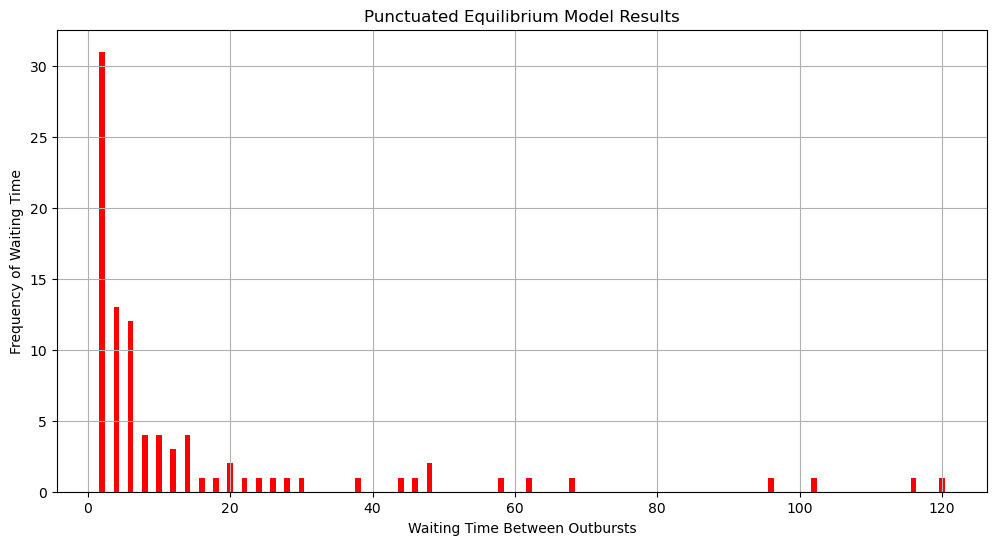

In [57]:
# figure5
import numpy as np
import matplotlib.pyplot as plt
model = EpsteinNetworkCivilViolence(
    width=40,
    height=40,
    citizen_density=0.7,
    cop_density=0.04,
    citizen_vision=2,
    cop_vision=2,
    legitimacy=0.88,
    max_jail_term=15,
    active_threshold=0.1,
    arrest_prob_constant=2.3,
    movement=True,
    max_iters=1000
)
for _ in range(1000):
    model.step()

data = model.datacollector.get_model_vars_dataframe()

# Assume model has been run and waiting_times have been collected as follows:
waiting_times = model.waiting_times

# Convert list to numpy array for easier manipulation
waiting_times_array = np.array(waiting_times)

# Get unique waiting times and their counts
unique_times, counts = np.unique(waiting_times_array, return_counts=True)

# Plotting the frequencies against the waiting times
plt.figure(figsize=(12, 6))
plt.bar(unique_times, counts, color='red')
plt.xlabel('Waiting Time Between Outbursts')
plt.ylabel('Frequency of Waiting Time')
plt.title('Punctuated Equilibrium Model Results')
plt.grid(True)
plt.show()

Active Count: 148
Active Count: 91
Outburst ends at step 3
Active Count: 61
Active Count: 66
Active Count: 55
Active Count: 65
Active Count: 57
Active Count: 61
Active Count: 73
Active Count: 77
Active Count: 74
Active Count: 85
Active Count: 82
Active Count: 92
Active Count: 79
Active Count: 77
Active Count: 79
Active Count: 84
Active Count: 82
Active Count: 78
Active Count: 81
Active Count: 82
Active Count: 77
Active Count: 93
Active Count: 98
Active Count: 93
Active Count: 87
Active Count: 90
Active Count: 88
Active Count: 94
Active Count: 95
Active Count: 105
Outburst starts, wait time recorded: 60
Active Count: 101
Active Count: 97
Outburst ends at step 67
Active Count: 101
Outburst starts, wait time recorded: 2
Active Count: 106
Active Count: 105
Active Count: 102
Active Count: 100
Active Count: 88
Outburst ends at step 79
Active Count: 89
Active Count: 90
Active Count: 95
Active Count: 92
Active Count: 86
Active Count: 89
Active Count: 88
Active Count: 83
Active Count: 81
Active

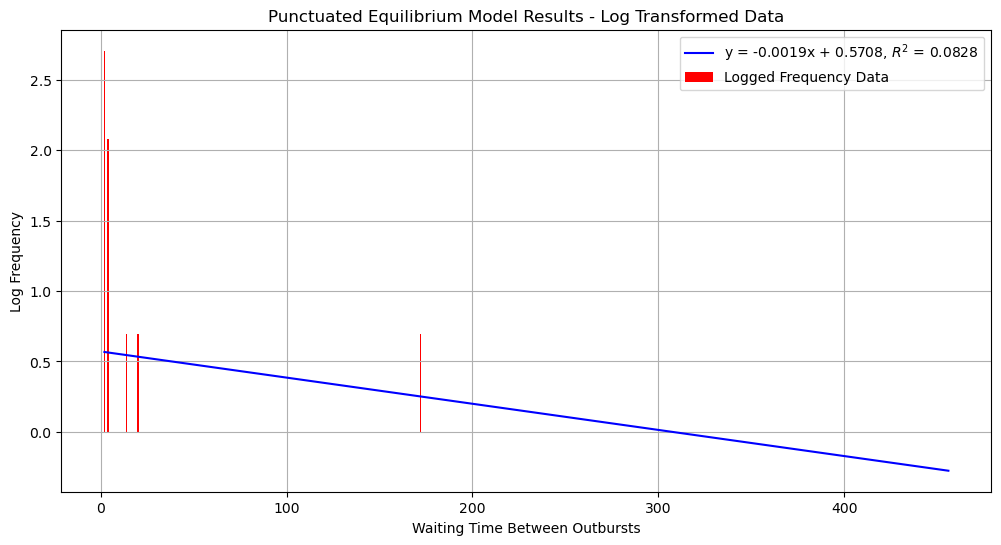

In [65]:
# figure6
from sklearn.linear_model import LinearRegression

# Assuming the simulation model has already been run, and waiting_times have been collected
simulation_model = EpsteinNetworkCivilViolence(
    width=40,
    height=40,
    citizen_density=0.7,
    cop_density=0.04,
    citizen_vision=2,
    cop_vision=2,
    legitimacy=0.88,
    max_jail_term=15,
    active_threshold=0.1,
    arrest_prob_constant=2.3,
    movement=True,
    max_iters=1000
)

for _ in range(1000):
    simulation_model.step()

waiting_times = simulation_model.waiting_times

# Convert the list to a numpy array for easier manipulation
waiting_times_array = np.array(waiting_times)

# Obtain unique waiting times and their counts
unique_times, counts = np.unique(waiting_times_array, return_counts=True)

# Log-transform the counts to prepare for regression analysis
log_freq = np.log(counts)

# Prepare data for linear regression
X = unique_times.reshape(-1, 1)
y = log_freq.reshape(-1, 1)

# Perform linear regression
regression_model = LinearRegression()
regression_model.fit(X, y)

# Get the regression line for plotting
line = regression_model.predict(X)

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(unique_times, log_freq, color='red', label='Logged Frequency Data')
plt.plot(unique_times, line, color='blue', label=f'y = {regression_model.coef_[0][0]:.4f}x + {regression_model.intercept_[0]:.4f}, $R^2$ = {regression_model.score(X, y):.4f}')
plt.xlabel('Waiting Time Between Outbursts')
plt.ylabel('Log Frequency')
plt.title('Punctuated Equilibrium Model Results - Log Transformed Data')
plt.legend()
plt.grid(True)
plt.show()

Active Count: 181
Active Count: 98
Outburst ends at step 3
Active Count: 57
Active Count: 53
Active Count: 53
Active Count: 68
Active Count: 65
Active Count: 84
Active Count: 88
Active Count: 103
Outburst starts, wait time recorded: 16
Active Count: 91
Outburst ends at step 21
Active Count: 85
Active Count: 97
Active Count: 103
Outburst starts, wait time recorded: 6
Active Count: 111
Active Count: 105
Active Count: 112
Active Count: 99
Outburst ends at step 35
Active Count: 93
Active Count: 88
Active Count: 91
Active Count: 95
Active Count: 100
Outburst starts, wait time recorded: 10
Active Count: 98
Outburst ends at step 47
Active Count: 100
Outburst starts, wait time recorded: 2
Active Count: 95
Outburst ends at step 51
Active Count: 94
Active Count: 87
Active Count: 89
Active Count: 92
Active Count: 92
Active Count: 91
Active Count: 92
Active Count: 87
Active Count: 87
Active Count: 90
Active Count: 96
Active Count: 95
Active Count: 96
Active Count: 98
Active Count: 98
Active Count:

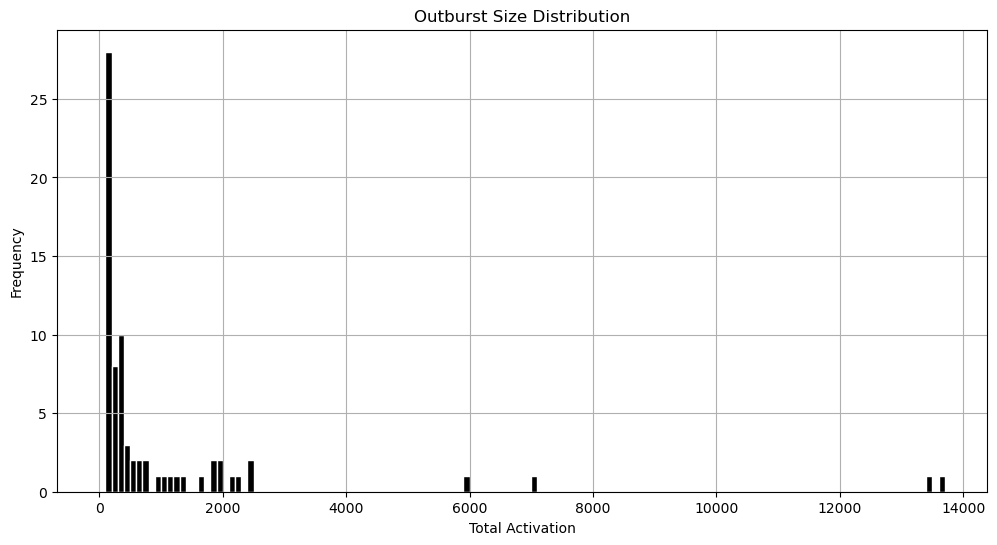

In [67]:
# figure7
model = EpsteinNetworkCivilViolence(
    width=40,
    height=40,
    citizen_density=0.7,
    cop_density=0.04,
    citizen_vision=2,
    cop_vision=2,
    legitimacy=0.88,
    max_jail_term=15,
    active_threshold=0.1,
    arrest_prob_constant=2.3,
    movement=True,
    max_iters=1000
)

for _ in range(1000):
    model.step()

# Data for plotting
outburst_sizes = model.outburst_sizes

# Define the bins for the histogram
bins = range(0, max(outburst_sizes) + 100, 100)  # Adjust bin size and range as needed

# Plotting
plt.figure(figsize=(12, 6))
plt.hist(outburst_sizes, bins=bins, color='black', edgecolor='white')
plt.xlabel('Total Activation')
plt.ylabel('Frequency')
plt.title('Outburst Size Distribution')
plt.grid(True)
plt.show()

Active Count: 551
Active Count: 377
Active Count: 249
Active Count: 200
Active Count: 159
Active Count: 151
Active Count: 155
Active Count: 155
Active Count: 164
Active Count: 150
Active Count: 169
Active Count: 174
Active Count: 171
Active Count: 205
Active Count: 222
Active Count: 222
Active Count: 231
Active Count: 254
Active Count: 239
Active Count: 232
Active Count: 240
Active Count: 230
Active Count: 240
Active Count: 228
Active Count: 236
Active Count: 228
Active Count: 243
Active Count: 239
Active Count: 242
Active Count: 247
Active Count: 253
Active Count: 259
Active Count: 259
Active Count: 257
Active Count: 256
Active Count: 243
Active Count: 236
Active Count: 245
Active Count: 247
Active Count: 250
Active Count: 245
Active Count: 251
Active Count: 238
Active Count: 231
Active Count: 240
Active Count: 240
Active Count: 236
Active Count: 246
Active Count: 239
Active Count: 231
Active Count: 231
Active Count: 240
Active Count: 241
Active Count: 251
Active Count: 243
Active Cou

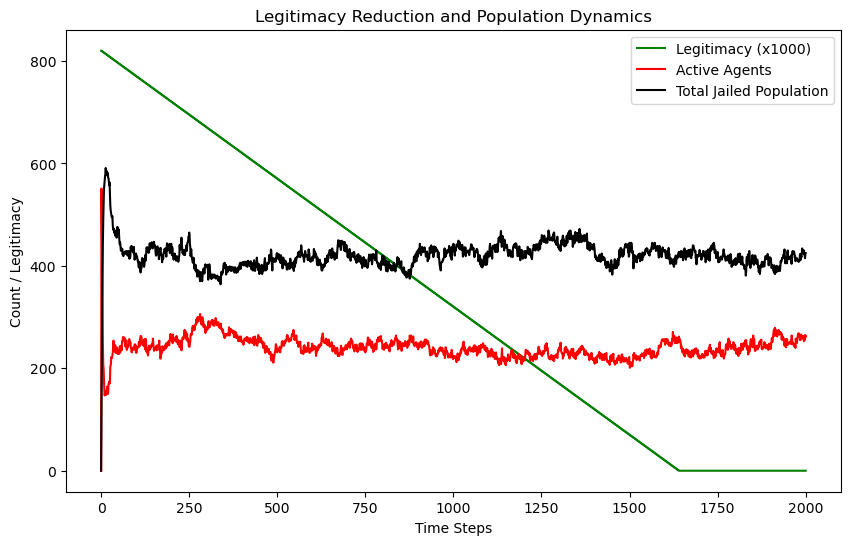

In [58]:
# Figure9&10
model = EpsteinNetworkCivilViolence(
    width=40, height=40, citizen_density=0.7, cop_density=0.04,
    citizen_vision=2, cop_vision=2, legitimacy=0.82, max_jail_term=30,
    active_threshold=0.1, arrest_prob_constant=2.3, movement=True, max_iters=1000, legitimacy_mode='gradual', cop_density_mode='constant'
)
for _ in range(1000):
    model.step()

data = model.datacollector.get_model_vars_dataframe()

# plot
plt.figure(figsize=(10, 6))
plt.plot(data['Legitimacy']*1000, label='Legitimacy (x1000)', color='green')
plt.plot(data['Active'], label='Active Agents', color='red')
plt.plot(data['Jailed'], label='Total Jailed Population', color='black')
plt.xlabel('Time Steps')
plt.ylabel('Count / Legitimacy')
plt.title('Legitimacy Reduction and Population Dynamics')
plt.legend()
plt.show()

Active Count: 724
Active Count: 615
Active Count: 525
Active Count: 463
Active Count: 410
Active Count: 379
Active Count: 344
Active Count: 332
Active Count: 340
Active Count: 341
Active Count: 329
Active Count: 337
Active Count: 339
Active Count: 317
Active Count: 304
Active Count: 289
Active Count: 305
Active Count: 319
Active Count: 319
Active Count: 335
Active Count: 314
Active Count: 314
Active Count: 319
Active Count: 305
Active Count: 327
Active Count: 318
Active Count: 310
Active Count: 303
Active Count: 294
Active Count: 291
Active Count: 299
Active Count: 305
Active Count: 302
Active Count: 303
Active Count: 294
Active Count: 297
Active Count: 283
Active Count: 289
Active Count: 292
Active Count: 288
Active Count: 295
Active Count: 291
Active Count: 309
Active Count: 309
Active Count: 301
Active Count: 310
Active Count: 325
Active Count: 318
Active Count: 312
Active Count: 310
Active Count: 298
Active Count: 294
Active Count: 294
Active Count: 292
Active Count: 290
Active Cou

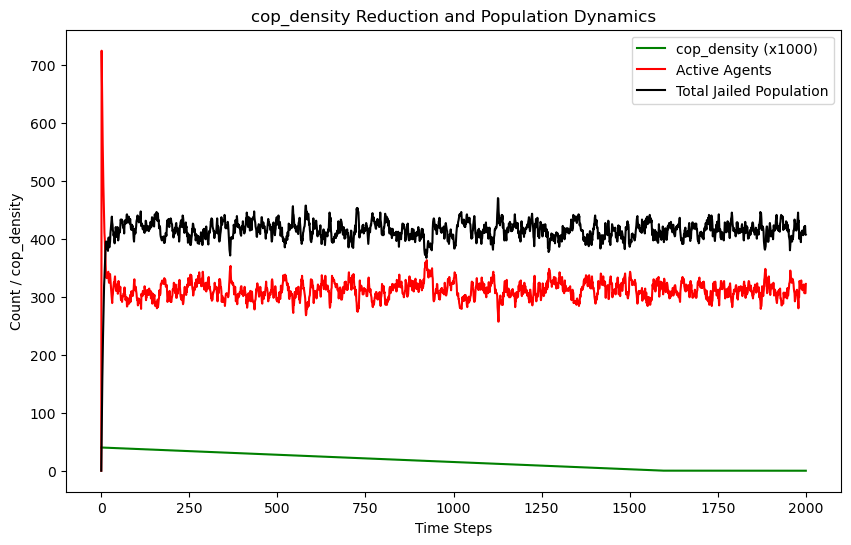

In [16]:
# Figure11
model = EpsteinNetworkCivilViolence(
    width=40, height=40, citizen_density=0.7, cop_density=0.04,
    citizen_vision=2, cop_vision=2, legitimacy=0.7, max_jail_term=15,
    active_threshold=0.1, arrest_prob_constant=2.3, movement=True, max_iters=1000, legitimacy_mode='constant', cop_density_mode='gradual'
)
for _ in range(1000):
    model.step()

data = model.datacollector.get_model_vars_dataframe()

# plot
plt.figure(figsize=(10, 6))
plt.plot(data['Cop_Density']*1000, label='cop_density (x1000)', color='green')
plt.plot(data['Active'], label='Active Agents', color='red')
plt.plot(data['Jailed'], label='Total Jailed Population', color='black')
plt.xlabel('Time Steps')
plt.ylabel('Count / cop_density')
plt.title('cop_density Reduction and Population Dynamics')
plt.legend()
plt.show()